In [2]:
import sys
import pandas as pd
import pickle
sys.path.append('../')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from api.utils.transformers import *

In [4]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

### Generate Training Data

In [5]:
generator = TrainingDataGenerator('../../Welcome-Centre-DataCorps-Data/ClientDatabaseStructure.mdb.sqlite')
training_data = generator.get_training_data(limit=100000)

### Build your Transformer and Choose Features

In [6]:
features_to_split = []

transformer = TransformerPipeline([
            ConsolidateTablesTransformer(),
            AddFutureReferralTargetFeatures(),
            TimeFeatureTransformer(break_length=28),
            SplitCurrentAndEverTransformer(['ReferralIssue_', 'ReferralDomesticCircumstances_',
                                            'ReferralReason_', 'ReferralBenefit_']),
            TimeWindowFeatures([1,4,10]),
        ], aligner=AlignFeaturesToColumnSchemaTransformer())

X, y, referral_table = transformer.fit_transform(training_data)

X = X.fillna(0)

100%|██████████| 107/107 [00:15<00:00,  7.05it/s]
../api/utils/transformers.py:281: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  lambda k: k.groupby(pd.TimeGrouper('1W', convention='e')).size())


In [29]:
X = X[referral_table['Referral_ReferralTakenDate'] < pd.to_datetime('2016-04-11')]

sorted_dates = referral_table.loc[X.index]['Referral_ReferralTakenDate'].sort_values()
test_start_date = sorted_dates.iloc[int(len(sorted_dates) * 0.8)]

X_train = X[referral_table['Referral_ReferralTakenDate'] < test_start_date]
X_test = X[referral_table['Referral_ReferralTakenDate'] >= test_start_date]
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


# Build a model

In [33]:
from sklearn.ensemble import ExtraTreesRegressor

In [34]:
et = ExtraTreesRegressor(n_jobs=-1, n_estimators=500)
et.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

# Evaluate model

In [39]:
y_pred = pd.Series(et.predict(X_test), X_test.index)

In [40]:
test_referral_table = referral_table.loc[X_test.index]

In [41]:
def get_scores_per_window(x, y, group, threshold=0.50):
    corr = spearmanr(x, y)[0]
    mu_a = x.groupby(group).mean()
    mu_p = y.groupby(group).mean()
    mu_a_top = mu_a[mu_a.rank(ascending=False) / len(mu_a) < threshold]
    mu_p_top = mu_p[mu_p.rank(ascending=False) / len(mu_p) < threshold]
    overlap = mu_p_top.index.isin(mu_a_top.index).mean()
    return pd.Series([corr, overlap], index=['spearman', 'overlap'])

In [42]:
def evaluate_average_weekly_rank_correlation(test_referral_table, y_test, y_pred):
    grouped_y = test_referral_table.assign(y=y_test, pred=y_pred).set_index('Referral_ReferralTakenDate')\
        .groupby([pd.TimeGrouper('1W'), 'Client_ClientId'])['y'].mean()
    grouped_pred_y = test_referral_table.assign(y=y_test, pred=y_pred).set_index('Referral_ReferralTakenDate')\
        .groupby([pd.TimeGrouper('1W'), 'Client_ClientId'])['pred'].mean()
    time_grouped = pd.concat([grouped_y, grouped_pred_y], axis=1)
    return time_grouped.reset_index().groupby(['Referral_ReferralTakenDate']).\
        apply(lambda k: get_scores_per_window(k['y'], k['pred'], k['Client_ClientId'])).dropna().mean()

In [43]:
evaluate_average_weekly_rank_correlation(test_referral_table, y_test, y_pred)

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


spearman    0.525839
overlap     0.712289
dtype: float64

### Evaluate the model results

SpearmanrResult(correlation=0.5411111821336304, pvalue=5.128211692535877e-187)


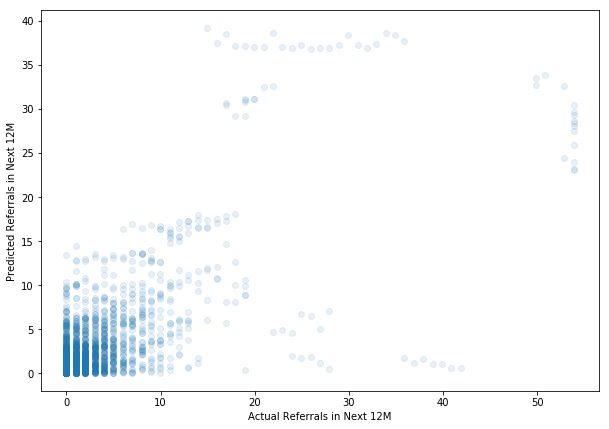

In [44]:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.scatter(x=y_test*52, y=y_pred*52, alpha=0.1)
ax.set_ylabel('Predicted Referrals in Next 12M')
ax.set_xlabel('Actual Referrals in Next 12M')
print(spearmanr(y_test, y_pred))

In [45]:
random_referral = test_referral_table.sample(1).iloc[0]
print(random_referral.name, y_test.loc[random_referral.name]*52, y_pred.loc[random_referral.name]*52)
random_client = random_referral['Client_ClientId']
(test_referral_table[test_referral_table['Client_ClientId']==random_client]
 [['FutureReferralTargetFeature_FutureReferralCount', 'Referral_ReferralTakenDate',
   'TimeFeature_ReferralNumber', 'TimeFeature_BurstNumber']])

10098 0.0 1.4559999999999906


,FutureReferralTargetFeature_FutureReferralCount,Referral_ReferralTakenDate,TimeFeature_ReferralNumber,TimeFeature_BurstNumber
9919,3.0,2015-11-02 13:29:00,10.0,7.0
10098,2.0,2015-11-12 13:04:00,11.0,7.0
10820,1.0,2015-12-29 13:55:00,12.0,8.0


### Evaluate a week

In [110]:
test_results = pd.concat([test_referral_table, y_pred,
                          X_test[['TimeFeature_IndexInBurst']]], axis=1).rename(columns={0:'predicted_score'})
test_results = test_results[['FutureReferralTargetFeature_FutureReferralScore',
                            'FutureReferralTargetFeature_FutureReferralCount', 'predicted_score',
                             'Referral_ReferralTakenDate', 'Client_ClientId', 'TimeFeature_ReferralNumber',
                             'TimeFeature_IndexInBurst'
                            ]]

In [112]:
week_groups = test_results.groupby(pd.Grouper(key='Referral_ReferralTakenDate', freq='W-MON'))
day_groups = test_results.groupby(pd.Grouper(key='Referral_ReferralTakenDate', freq='D'))

In [120]:
week_group = week_groups.get_group('2015-12-14')
day_group = day_groups.get_group('2016-04-05')

In [101]:
for k, group in day_groups:
    print(k, spearmanr(group['FutureReferralTargetFeature_FutureReferralScore'],
              group['predicted_score']))

2015-11-02 00:00:00 SpearmanrResult(correlation=0.6533680848738441, pvalue=0.011280295554804635)
2015-11-03 00:00:00 SpearmanrResult(correlation=0.8181352530581268, pvalue=5.987542718065549e-05)
2015-11-04 00:00:00 SpearmanrResult(correlation=0.3276256433110614, pvalue=0.13663546475009208)
2015-11-05 00:00:00 SpearmanrResult(correlation=0.7171769628291058, pvalue=0.0008082172685214856)
2015-11-06 00:00:00 SpearmanrResult(correlation=0.6710895449423603, pvalue=0.00045597534206434344)
2015-11-07 00:00:00 SpearmanrResult(correlation=nan, pvalue=nan)
2015-11-08 00:00:00 SpearmanrResult(correlation=nan, pvalue=nan)
2015-11-09 00:00:00 SpearmanrResult(correlation=0.7452274764498256, pvalue=3.5213343441678516e-06)
2015-11-10 00:00:00 SpearmanrResult(correlation=0.46023032816787324, pvalue=0.02061446989043968)
2015-11-11 00:00:00 SpearmanrResult(correlation=0.5703357039577539, pvalue=0.004488534727151008)
2015-11-12 00:00:00 SpearmanrResult(correlation=0.5743540120186023, pvalue=0.004153893760

2016-02-05 00:00:00 SpearmanrResult(correlation=0.7736278174936575, pvalue=0.0007148764564559463)
2016-02-06 00:00:00 SpearmanrResult(correlation=nan, pvalue=nan)
2016-02-07 00:00:00 SpearmanrResult(correlation=nan, pvalue=nan)
2016-02-08 00:00:00 SpearmanrResult(correlation=0.5405192190532656, pvalue=0.0024690801071543234)
2016-02-09 00:00:00 SpearmanrResult(correlation=0.5943474453223476, pvalue=0.00449295743065289)
2016-02-10 00:00:00 SpearmanrResult(correlation=0.7373340397130613, pvalue=0.0004800071958983604)
2016-02-11 00:00:00 SpearmanrResult(correlation=0.559834910354971, pvalue=0.006740780786585267)
2016-02-12 00:00:00 SpearmanrResult(correlation=0.5379927730389734, pvalue=0.003797565987578882)
2016-02-13 00:00:00 SpearmanrResult(correlation=nan, pvalue=nan)
2016-02-14 00:00:00 SpearmanrResult(correlation=nan, pvalue=nan)
2016-02-15 00:00:00 SpearmanrResult(correlation=0.638396488189155, pvalue=0.0024518987237334196)
2016-02-16 00:00:00 SpearmanrResult(correlation=0.2640621751

/Users/davidsykes/.virtualenvs/twc/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


SpearmanrResult(correlation=0.6000609272213587, pvalue=0.0009373590214966779)


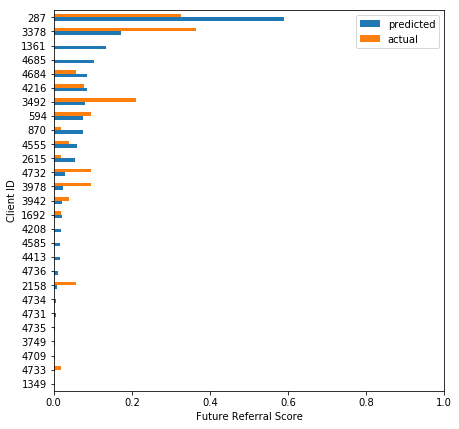

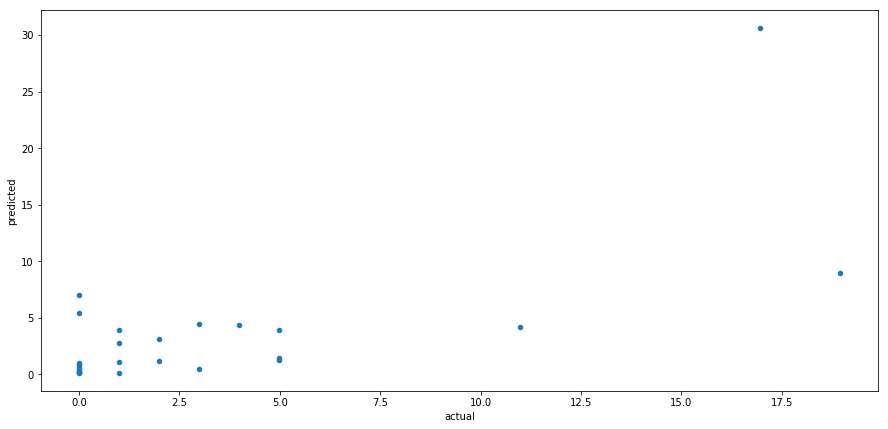

In [138]:
def plot_group_bars(group, columns_to_plot=['predicted', 'actual'], ordered_by='predicted'):
    fig, ax = plt.subplots(1, figsize=(7,7))
    for_plot = group.set_index('Client_ClientId')
    for_plot =  for_plot[['predicted_score', 'FutureReferralTargetFeature_FutureReferralScore']]
    for_plot.columns = ['predicted', 'actual']
    if ordered_by:
        for_plot = for_plot.sort_values(ordered_by)
    for_plot = for_plot[columns_to_plot]
    for_plot.plot(kind='barh', ax=ax)
    ax.set_ylabel('Client ID')
    ax.set_xlabel('Future Referral Score')
    ax.set_xlim((0,1))
    
def plot_group_scatter(group):
    fig, ax = plt.subplots(1, figsize=(15,7))
    for_plot = group.set_index('Client_ClientId')
    for_plot =  for_plot[['predicted_score', 'FutureReferralTargetFeature_FutureReferralScore']]*52
    for_plot.columns = ['predicted', 'actual']
    for_plot.sort_values('predicted').plot(kind='scatter',x='actual', y='predicted', ax=ax)

day_group['Client_ClientId'] = day_group['Client_ClientId'].astype(int)
# day_group['FutureReferralTargetFeature_FutureReferralScore']=0
# day_group['predicted_score'] = 0
plot_group_bars(day_group, columns_to_plot=['predicted', 'actual'], ordered_by='predicted')
plot_group_scatter(day_group)
print(spearmanr(day_group['FutureReferralTargetFeature_FutureReferralScore'],
              day_group['predicted_score']))

In [140]:
day_group.set_index('Client_ClientId').loc[1361]

FutureReferralTargetFeature_FutureReferralScore                      0
FutureReferralTargetFeature_FutureReferralCount                      0
predicted_score                                               0.134285
Referral_ReferralTakenDate                         2016-04-05 16:20:00
TimeFeature_ReferralNumber                                          25
TimeFeature_IndexInBurst                                             1
Name: 1361, dtype: object

### Plot predicted score vs burst number

(-30, 30)

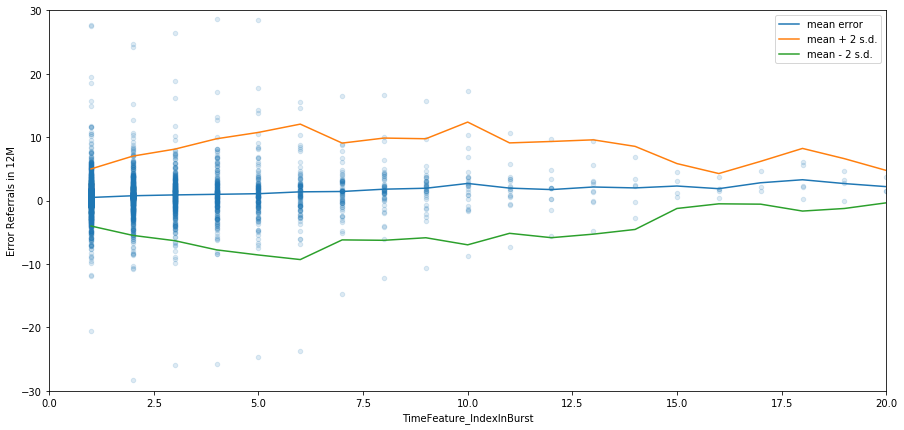

In [90]:
test_all = pd.concat([test_referral_table, y_pred, X_test], axis=1).rename(columns={0:'predicted_score'})
test_all['error'] = (test_all['predicted_score'] 
                     - test_all['FutureReferralTargetFeature_FutureReferralScore'])*52

test_all = test_all[test_all['TimeFeature_IndexInBurst'] % 1 == 0]

ax = test_all.plot(kind='scatter', x='TimeFeature_IndexInBurst', y='error', alpha=0.15, figsize=(15,7))
ax.set_xlim(0,20)
means = test_all.groupby('TimeFeature_IndexInBurst')['error'].mean()
sd = test_all.groupby('TimeFeature_IndexInBurst')['error'].std()
upper = means + 2*sd
lower = means - 2*sd
means.plot(ax=ax, label='mean error', legend=True)
upper.plot(ax=ax, label='mean + 2 s.d.', legend=True)
lower.plot(ax=ax, label='mean - 2 s.d.', legend=True)
ax.set_ylabel('Error Referrals in 12M')
ax.set_ylim((-30,30))

In [76]:
test_all.groupby('TimeFeature_IndexInBurst')['error'].mean()

TimeFeature_IndexInBurst
1.0      0.498820
1.5      5.277003
2.0      0.771125
2.5      3.591134
3.0      0.901759
4.0      0.996505
5.0      1.094180
6.0      1.386071
7.0      1.440824
8.0      1.805550
9.0      1.953552
10.0     2.709889
11.0     1.974810
12.0     1.743392
13.0     2.151290
14.0     2.005490
15.0     2.303671
16.0     1.884423
17.0     2.818922
18.0     3.293751
19.0     2.691107
20.0     2.208599
21.0     2.144774
22.0     3.975744
23.0     5.796742
24.0     5.604603
25.0     7.758685
26.0     9.078393
27.0     9.299784
28.0    10.872796
          ...    
40.0    23.369797
41.0    12.165578
42.0    12.615342
43.0    13.056132
44.0    -0.213414
45.0    -0.207430
46.0    -0.087759
47.0    -0.239342
48.0     2.086268
49.0     2.012471
50.0     2.937929
51.0     3.944164
52.0     4.822751
53.0     5.992537
54.0     6.952899
55.0     7.104482
56.0     7.978082
57.0     9.071079
58.0     9.948668
59.0    11.089534
60.0    12.086795
61.0    12.964384
62.0    14.081315
63.

### Feature Importance

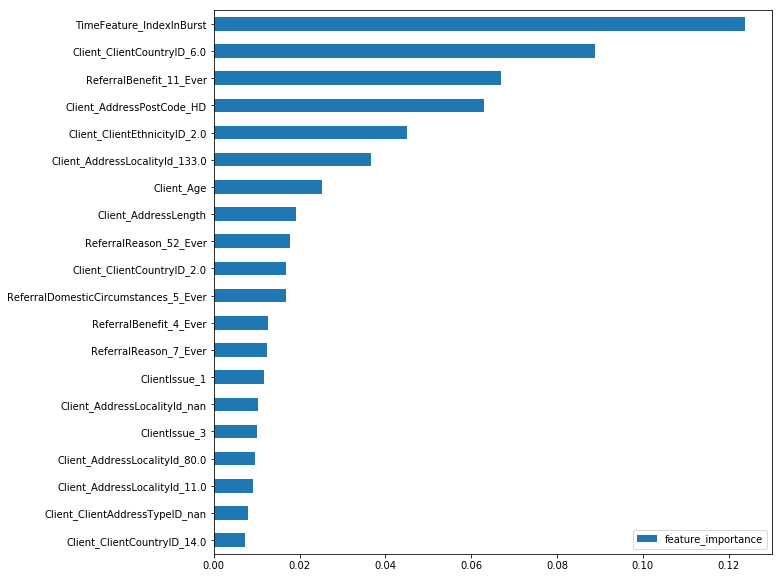

In [54]:
pd.DataFrame(index=X.columns,
             data={'feature_importance':et.feature_importances_}).sort_values('feature_importance'
                                                                             ).tail(20).plot(kind='barh',
                                                                                            figsize=(10,10))

# Save your model

In [ ]:
from api.utils.models import TWCModel

In [ ]:
model = TWCModel()
model.transformer = transformer
model.model = et
model.save('etmodel.p')

In [ ]:
model2 = TWCModel()

In [ ]:
model2.load('etmodel.p')

### Test your model works on json test file

In [ ]:
with open('../api/twc_sample_request.json') as f:
    json_string = f.read()

In [ ]:
p = ParseJSONToTablesTransformer()
example_tables = p.fit_transform(json_string)

In [ ]:
model2.transformer.fit_transform(example_tables)